In [60]:
import pyodbc
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

In [61]:
# kết nối đén sql server
load_dotenv()
server = os.getenv('SERVER')
database = os.getenv('DATABASE')

if server is None or database is None:
    print("Please set the environment variables 'SERVER' and 'DATABASE'")
    exit()

try:
    # Kết nối đến cơ sở dữ liệu
    connection = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + server + 
        ';DATABASE=' + database + 
        ';Trusted_Connection=yes;'
    )

    collection = 'pudgypenguins'
    query_collection = f"SELECT * FROM collections WHERE collection_slug = '{collection}'"
    query_nfts = f"SELECT * FROM nfts_infor WHERE collection = '{collection}'"
    query_transactions = f"""SELECT t.* FROM transaction_infor t 
                                JOIN nfts_infor n ON t.name = n.name 
                                WHERE n.collection = '{collection}'"""
    

    df_collection = pd.read_sql(query_collection,connection)
    if df_collection.empty:
        print("No data in collection")
    df_nfts = pd.read_sql(query_nfts, connection)
    if df_nfts.empty:
        print("No data in nfts")
    df_transactions = pd.read_sql(query_transactions, connection)
    if df_transactions.empty:
        print("No data in transactions")

    # Đóng kết nối
    connection.close()
except pyodbc.Error as ex:
    print("Error connecting to database:", ex)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4872\2103086568.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_collection = pd.read_sql(query_collection,connection)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4872\2103086568.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nfts = pd.read_sql(query_nfts, connection)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4872\2103086568.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql(query_transactions, connection)


In [62]:
df_collection

,collection_slug,name,owner,contracts_address
0,pudgypenguins,Pudgy Penguins,0xf54c9a0e44a5f5afd27c7ac8a176a843b9114f1d,0xbd3531da5cf5857e7cfaa92426877b022e612cf8


In [63]:
# những cột của df_nfts
df_nfts.columns

Index(['tokenid', 'name', 'owners_address', 'collection', 'quantity',
       'update_date', 'update_time'],
      dtype='object')

In [64]:
# df_nfts chua cac thong tin ve nft cua 1 collection
# phân bố nắm giữ
df_owners = df_nfts.groupby('owners_address')[['quantity']].sum().sort_values(by ='quantity', ascending= False)
# tỷ lệ phân bổ của những token này
df_owners['owned'] = df_owners['quantity']/ df_owners['quantity'].sum()*100
df_owners.head(10)

,quantity,owned
owners_address,,
0x29469395eaf6f95920e59f858042f0e28d98a20b,307,3.454484
0x3f22fc93143790a1bd11c37c65a0a0f7e7875ea2,161,1.811635
0x6138d1073b63e33b97771a4ab8b361617d6b53c3,93,1.046472
0x3eb879cc9a0ef4c6f1d870a40ae187768c278da2,71,0.798920
0x4182a46c61c3ee40e61304f8b419f813eeced3b4,68,0.765163
0x796b157c2a4f01663934b04cc11e61a920711d32,45,0.506358
0x29f1abd903f2293d062307d1ff4e25697a05986f,41,0.461348
0x0000000044638842d0e30f6ff587cd99650526fa,39,0.438843
0xfdd6cc8f6849e82f5e0102057fa74941024d11b6,39,0.438843


In [65]:
# Địa chỉ ví của người tạo ra
creator_address = df_collection['owner'].iloc[0]

# Loc những nft thuộc chủ sở hữu
creator_nfts = df_nfts[df_nfts['owners_address'] == creator_address]

# Tính toán số lượng nft 
num_nft_creator = creator_nfts['quantity'].sum()
num_nft_others = df_nfts['quantity'].sum() - num_nft_creator

# In kết quả
print("Số lượng NFT của creator:", num_nft_creator)
print("Số lượng NFT của những người còn lại:", num_nft_others)

Số lượng NFT của creator: 0
Số lượng NFT của những người còn lại: 8887


In [66]:
# tính số lượng người nắm giữ 1, 2-3,4-10, 11-25, 26-50, 50+
owned_1 = df_owners[df_owners['quantity'] == 1].shape[0]
owned_2_3 = df_owners[(df_owners['quantity'] >= 2) & (df_owners['quantity'] <= 3)].shape[0]
owned_4_10 = df_owners[(df_owners['quantity'] >= 4) & (df_owners['quantity'] <= 10)].shape[0]
owned_11_plus = df_owners[(df_owners['quantity'] >= 11)].shape[0]
total_quantity = df_owners['quantity'].sum()


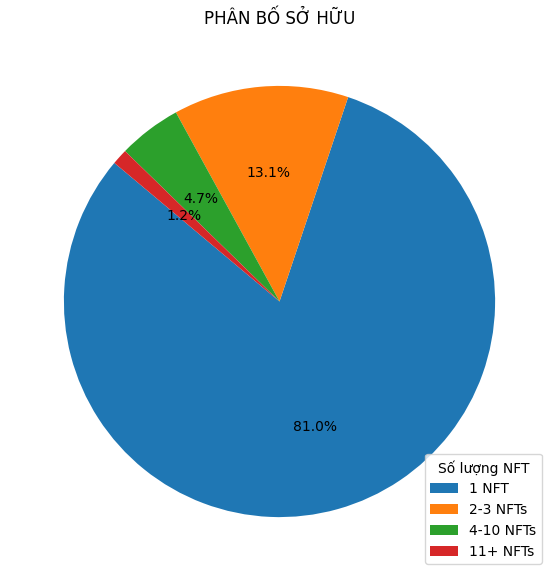

In [67]:

fig, ax = plt.subplots(figsize=(7, 7))

labels = ["1 NFT", "2-3 NFTs", "4-10 NFTs", "11+ NFTs"]
percentages = [
    (owned_1 / total_quantity) * 100,
    (owned_2_3 / total_quantity) * 100,
    (owned_4_10 / total_quantity) * 100,
    (owned_11_plus / total_quantity) * 100,
]

# Create pie chart
wedges, texts, autotexts = ax.pie(
    percentages, labels=None, autopct="%1.1f%%", startangle=140
)

# Add legend
plt.legend(wedges, labels, title="Số lượng NFT")

# Set chart title
ax.set_title("PHÂN BỐ SỞ HỮU")

plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4872\204781037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'].dt.date


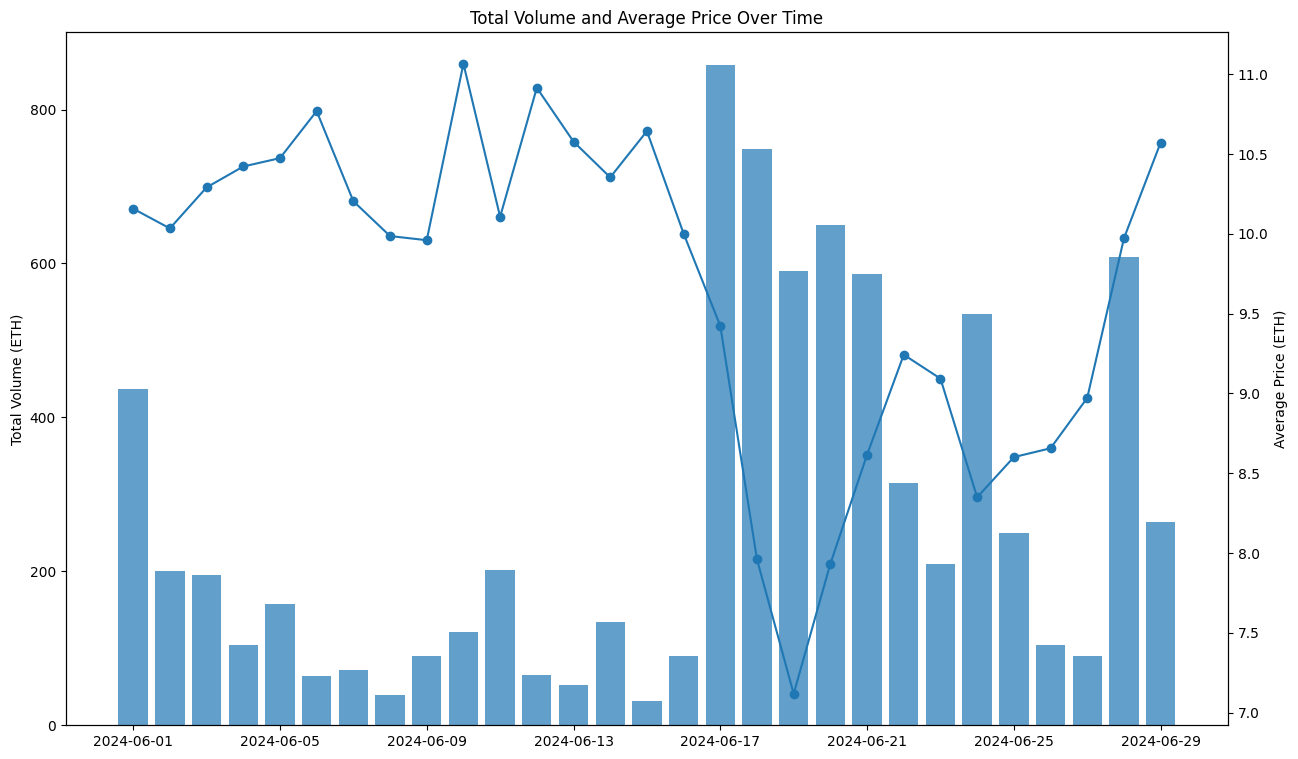

In [68]:
# volumn
df = df_transactions[['time','price']]
df['time'] = df['time'].dt.date
# Calculate average price
df_avg_price = df.groupby('time')['price'].mean().reset_index()
df_avg_price.columns = ['time', 'avg_price']

# Calculate total volume (sum of prices)
df_volume = df.groupby('time')['price'].sum().reset_index()
df_volume.columns = ['time', 'total_volume']

# Merge the two DataFrames based on 'event_timestamp'
df_combined = pd.merge(df_avg_price, df_volume, on='time')

df_plot = pd.DataFrame(df_combined)


# Tạo figure và axes
fig, ax1 = plt.subplots(figsize=(15,9))

# Vẽ biểu đồ cột trên trục ax1
ax1.bar(df_combined['time'],df_combined['total_volume'], alpha=0.7)
ax1.set_ylabel('Total Volume (ETH)')
ax1.tick_params(axis='y')

# Tạo một secondary y-axis
ax2 = ax1.twinx()

# Vẽ biểu đồ đường trên trục ax2
ax2.plot(df_combined['time'], df_combined['avg_price'], marker='o')
ax2.set_ylabel('Average Price (ETH)')
ax2.tick_params(axis='y')

# Đặt tiêu đề cho biểu đồ và cho các trục
plt.title('Total Volume and Average Price Over Time')
plt.xlabel('Event Timestamp')

# Hiển thị biểu đồ
plt.show()

<Axes: title={'center': 'Giá theo thời gian'}, xlabel='Date', ylabel='price'>

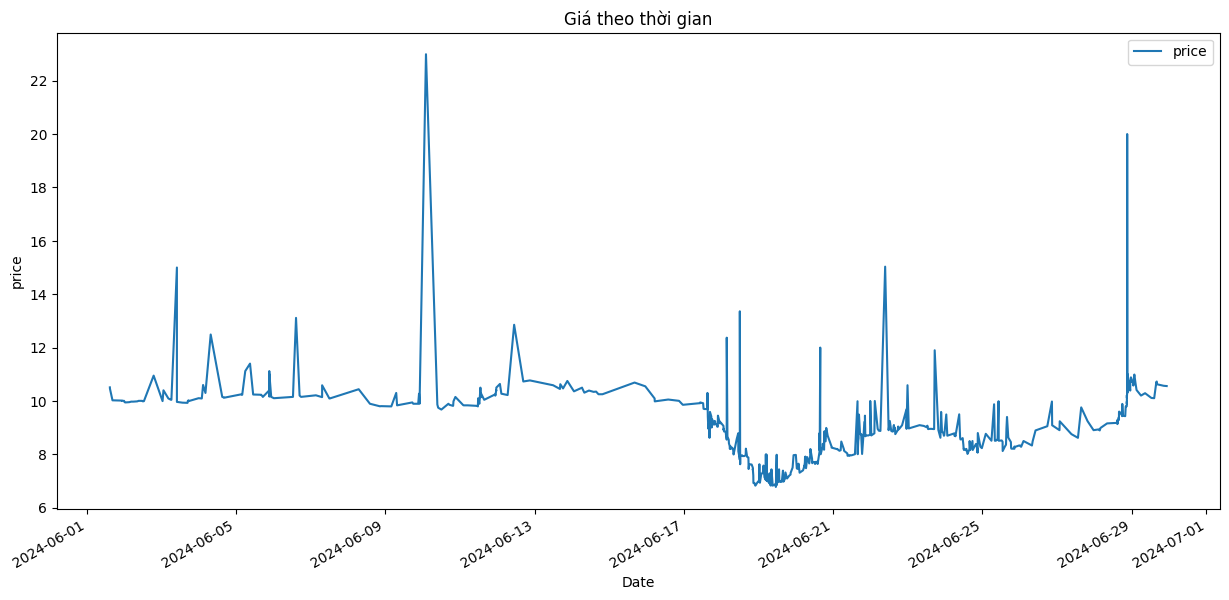

In [69]:
df_transactions=df_transactions.sort_values(by='time')
# vẽ biểu đồ price theo thời gian
df_transactions.plot(y='price', x='time', title='Giá theo thời gian', ylabel='price', xlabel='Date', figsize=(15,7))